# Pytroch Classification (Neural Network)

In [739]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)
X.shape, y.shape


((1000, 2), (1000,))

In [740]:
print("First 5 sample of X : \n", X[:5].shape)
print("First 5 sample of Y : \n", y[:5].shape)

First 5 sample of X : 
 (5, 2)
First 5 sample of Y : 
 (5,)


# Convert into dataframe

In [741]:
import pandas as pd

circles_df = pd.DataFrame({"X1":X[:,0], "X2":X[:,1], "y":y})
circles_df.head()

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [742]:
circles_df.corr()

,X1,X2,y
X1,1.000000,-0.001138,-0.000765
X2,-0.001138,1.000000,0.000183
y,-0.000765,0.000183,1.000000


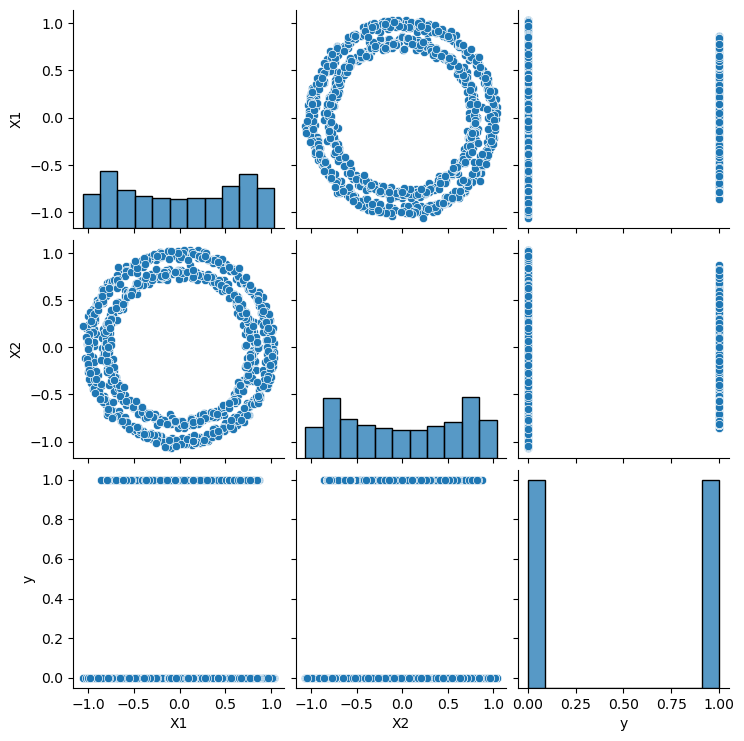

In [743]:
import seaborn as sns

sns.pairplot(circles_df)

In [744]:
x1 = circles_df[y == 0]["X1"]
x2 = circles_df[y == 0]["X2"]

x1.shape


(500,)

# Potting the Dataframe

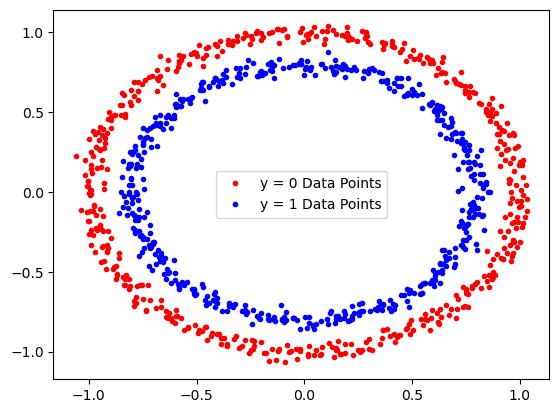

In [745]:
import matplotlib.pyplot as plt

plt.plot(circles_df[y == 0]["X1"], circles_df[y == 0]["X2"], "r.", label="y = 0 Data Points")
plt.plot(circles_df[y == 1]["X1"], circles_df[y == 1]["X2"], "b.", label="y = 1 Data Points")
plt.legend()
plt.show()

# Changing to Standarad Scaler

In [746]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# y = y.reshape(-1,1)
# y = scaler.transform(y)
# X.shape, y.shape

# Train Test Split

In [747]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape
# X_train

((700, 2), (700,))

In [748]:
# X_train[y_train == 0][:,0]

# Plotting the Train Data

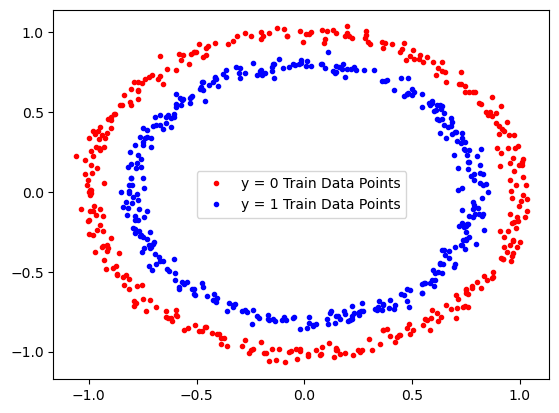

In [749]:
import matplotlib.pyplot as plt

plt.plot(X_train[y_train == 0][:,0], X_train[y_train == 0][:,1], "r.", label="y = 0 Train Data Points")
plt.plot(X_train[y_train == 1][:,0], X_train[y_train == 1][:,1], "b.", label="y = 1 Train Data Points")
plt.legend()
plt.show()

# Convert the Numpy Array into Tensors

In [750]:
type(X_train), X_train.shape, y_train.shape

(numpy.ndarray, (700, 2), (700,))

In [751]:
# y_train = y_train.reshape(-1,1)
type(X_train), X_train.shape, y_train.shape


(numpy.ndarray, (700, 2), (700,))

In [752]:
import torch

X_train_tensor = torch.from_numpy(X_train).type(torch.float)
y_train_tensor = torch.from_numpy(y_train).type(torch.float)

X_test_tensor = torch.from_numpy(X_test).type(torch.float)
y_test_tensor = torch.from_numpy(y_test).type(torch.float)

X_train_tensor.shape, y_train_tensor.shape

(torch.Size([700, 2]), torch.Size([700]))

a## 0. Architecture of a classification neural network

Before we get into writing code, let's look at the general architecture of a classification neural network.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, haeight, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |

Of course, this ingredient list of classification neural network components will vary depending on the problem you're working on.

But it's more than enough to get started.

We're going to get hands-on with this setup throughout this notebook.

# Basics About the above problems

`No. of Input Features` = 2 (X1/X2)

`No of Output (Class)` = 2 (0/1)

In [753]:
X_train_tensor.shape, y_train_tensor.shape
# /64

(torch.Size([700, 2]), torch.Size([700]))

In [754]:
X_train_tensor[2], y_train_tensor[2]

(tensor([0.9073, 0.1618]), tensor(0.))

# Build A Model to classify blue and red dots

* consturct a model by using subclass nn.modules
* Loss function and optimizer
* training and test loop 


In [755]:
import torch 
from torch import nn

In [756]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [757]:
class ClassficationSolverCircle(nn.Module):
    def __init__(self, X):
        super().__init__()
        # create 2 nn.linear layer
        # torch.manual_seed(42)
        no_of_feature = X.shape[1]
        self.layer1 = nn.Linear(in_features=no_of_feature, out_features=4)
        self.layer3 = nn.Linear(in_features=4, out_features=4)
        self.layer2 = nn.Linear(in_features=4, out_features=1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer3(x)
        return self.layer2(x)

torch.manual_seed(42)

model = ClassficationSolverCircle(X)
print(model)
print(model.state_dict())


ClassficationSolverCircle(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (layer3): Linear(in_features=4, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=1, bias=True)
)
OrderedDict({'layer1.weight': tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153]]), 'layer1.bias': tensor([ 0.6233, -0.5188,  0.6146,  0.1323]), 'layer3.weight': tensor([[ 0.3694,  0.0677,  0.2411, -0.0706],
        [ 0.3854,  0.0739, -0.2334,  0.1274],
        [-0.2304, -0.0586, -0.2031,  0.3317],
        [-0.3947, -0.2305, -0.1412, -0.3006]]), 'layer3.bias': tensor([ 0.0472, -0.4938,  0.4516, -0.4247]), 'layer2.weight': tensor([[ 0.3860,  0.0832, -0.1624,  0.3090]]), 'layer2.bias': tensor([0.0779])})


In [758]:
model.parameters

<bound method Module.parameters of ClassficationSolverCircle(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (layer3): Linear(in_features=4, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=1, bias=True)
)>

# Creating above model using sequential

In [759]:
model_1 = nn.Sequential(
    nn.Linear(in_features = 2, out_features=4),
    nn.Linear(in_features = 4, out_features=1)
)
model_1

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=1, bias=True)
)

In [760]:
# prediction using our model
with torch.inference_mode():
    ypre = model(X_test_tensor)
ypre.shape

torch.Size([300, 1])

# Loss function and optimizer

In [761]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.01)

# Accuarcy

In [762]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Raw Logits -> Prediction Probabilities -> Prediction Labels

`Since we are using the BCELossWithLogits`

we can convert these **logits** into **prediction probabilites** by passing them to some kind of **activation function** (e.g. `sigmoid for binary classificaiton and softmax for multiclass classfication`)

then we can convfert ourr models **predicted probabalities** to **prediction labesl** by either **rounding** up or taking the **argmax()**

In [763]:
y_pred_labels = torch.round(torch.sigmoid(model(X_train_tensor)))
y_pred_labels.shape


torch.Size([700, 1])

# Training and Testing loop

In [764]:
epochs = 100
# print(X_train_tensor.shape, y_train_tensor.shape)

for i in range(epochs):
    # train
    model.train()
    # forward pass
    y_logits = model(X_train_tensor).squeeze()
    y_pred_labels = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train_tensor) # nn.BCELossWitheLogits expects the logits
    # l = loss_fn(torch.sigmoid(y_logits), y_train_tensor) # nn.BCELoss expects the prediction probabilites
    acc = accuracy_fn(y_true=y_train_tensor, y_pred=y_pred_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ((i+1) % 50) == 0:
        print(f"Epoch [{i+1}/{epochs}] :: Accuracy is ({acc:.2f}) % and Loss is {loss:.2f}")

Epoch [50/100] :: Accuracy is (54.00) % and Loss is 0.69
Epoch [100/100] :: Accuracy is (53.71) % and Loss is 0.69


# Testing

In [765]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_test_tensor).squeeze()
    y_pred_labels = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_test_tensor)
    acc = accuracy_fn(y_true=y_test_tensor, y_pred=y_pred_labels)

print(f"Accuarcy of Test Dataset :: {acc:.2f} %")

Accuarcy of Test Dataset :: 50.33 %


In [766]:
type(X)

numpy.ndarray

# Visualisation

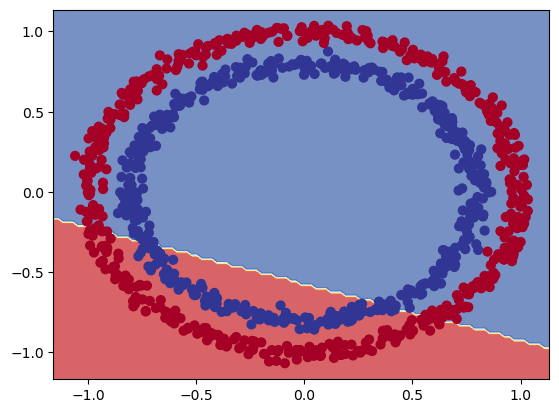

In [767]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1  # x0 features
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1  # x1 features
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)
    y = torch.from_numpy(y)
    # print(torch.unique(y))
    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

plot_decision_boundary(model, X,y)